# CNN and Computer Vision - Exercises

## 1. Spend 20-minutes reading and interacting with the CNN explainer website.

* What are the key terms? e.g. explain convolution in your own words, pooling in your own words

## 2. Play around with the "understanding hyperparameters" section in the CNN explainer website for 10-minutes.

* What is the kernel size?
* What is the stride?
* How could you adjust each of these in TensorFlow code?

## 3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here. 

## 4. Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

### Functions

In [63]:
import os
import numpy as np
import tensorflow as tf

In [64]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [65]:
!ls /content/drive/MyDrive/Space_Images_Dataset 

Earth  Galaxy  Jupiter	Mars  Neptune  Sun


In [66]:
class_names = [
    'Sun', 'Neptune', 'Mars', 'Jupiter', 'Galaxy', 'Earth'
]
class_names

['Sun', 'Neptune', 'Mars', 'Jupiter', 'Galaxy', 'Earth']

In [67]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# images must be saved sub folders of their class
def get_images_labels(target_dir, class_names, resize=None):
  # Setup target directory (we'll view images from here)
  labels = []
  imgs = []
  for idx, class_dir in enumerate(class_names):
    target_folder = target_dir+class_dir

    for img_file in os.listdir(target_folder):
      img = cv2.imread(target_folder + "/" + img_file)
      if resize: img = cv2.resize(img, resize)
      imgs.append(img)

      labels.append(idx)

  return (np.array(imgs), np.array(labels))

In [68]:
# view any image (at idx) from (imgs, labels) as output by "get_images_labels" function 
def view_image(imgs, labels, idx, class_names):
  img = imgs[idx]
  plt.imshow(img)
  plt.title(class_names[labels[idx]])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image



In [69]:
# view any image at random index from (imgs, labels) as output by "get_images_labels" function 
def view_random_image(imgs, labels, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]
  plt.imshow(img)

  shp = labels.shape
  label_idx = labels[idx]  
  if len(shp)==2: # if one hot encoded
    label_idx = tf.where(label_idx==1)[0][0]

  plt.title(class_names[label_idx])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image


In [70]:
def pred_and_plot(model, imgs, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))[0]

  # Get the predicted class
  if len(pred)==1: 
    pred_class = class_names[round(pred[0])]
  else:
    pred_class = class_names[int(tf.argmax(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### Multi-class Classification: Celestial Objects

In [71]:
parent_dir = '/content/drive/MyDrive/Space_Images_Dataset/'

In [72]:
(X, Y) = get_images_labels(parent_dir, class_names, resize=(224, 224))

In [73]:
Y = tf.one_hot(Y, 6)
Y

<tf.Tensor: shape=(300, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [74]:
# will split images and labels into training and test (or validation) data
# images must be array length N x w x h x 3.
# labels must be Nx1 (sparse) or Nxdepth (not sparse)
# All images and labels must be in synchronous.
# There must be same number images for each label.
# All images must be ordered by label, where all images from first label come first, then
# all images from second label come second, and so on
# depth is number of classes
# split must be split size; data will be shuffled prior to split
def images_labels_split(imgs, lbls, depth, split=.2):
  train_imgs = []
  train_lbls = []
  
  test_imgs = []
  test_lbls = []

  N = len(imgs)
  
  if N!=len(lbls): raise Exception

  # size of images for each label
  n = int(N/depth)

  for k in range(depth):
    
    inds = np.linspace(0, n-1, n)
    np.random.shuffle(inds)

    ind_split = n - int(n*split)
    train_inds = inds[:ind_split]
    test_inds = inds[ind_split:]
    
    for train_ind in train_inds:
      train_ind = int(train_ind+k*n)
      train_imgs.append(imgs[train_ind])
      train_lbls.append(lbls[train_ind])


    for test_ind in test_inds:
      test_ind = int(test_ind+k*n)
      test_imgs.append(imgs[test_ind])
      test_lbls.append(lbls[test_ind])

  return (np.array(train_imgs), np.array(train_lbls), np.array(test_imgs), np.array(test_lbls))




In [75]:
X_train, Y_train, X_test, Y_test = images_labels_split(X, Y, depth=6, split=.2)

In [76]:
X_train.shape

(240, 224, 224, 3)

In [77]:
X_test.shape

(60, 224, 224, 3)

In [78]:
Y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [79]:
Y_test

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)



In [81]:
train_data = datagen.flow(X_train, Y_train, batch_size=32, seed=42)

In [82]:
train_data[5]

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.8980393 , 0.8980393 , 0.8980393 ],
          [0.90196085, 0.90196085, 0.90196085],
          [0.8980393 , 0.8980393 , 0.8980393 ]],
 
         [[1.        , 1.        , 1.        ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.90196085, 0.90196085, 0.90196085],
          [0.909804  , 0.909804  , 0.909804  ],
          [0.90196085, 0.90196085, 0.90196085]],
 
         [[1.        , 1.        , 1.        ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.9058824 , 0.9058824 , 0.9058824 ],
          [0.9058824 , 0.9058824 , 0.9058824 ],
          [0.90196085, 0.90196085, 0.90196085]],
 
         ...,
 
         [[0.92549026, 0.92549026, 0.92549026],
          [0.93333

In [83]:
test_data = datagen.flow(X_test, Y_test, batch_size=32, seed=42)

In [84]:
test_data[1]

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

Image shape: (224, 224, 3)


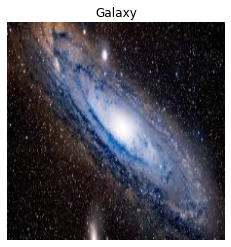

In [85]:
view_random_image(X, Y, class_names)

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(6, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
8/8 [==============================] - 2s 80ms/step - loss: 1.6381 - accuracy: 0.2792 - val_loss: 1.3946 - val_accuracy: 0.5167
Epoch 2/5
8/8 [==============================] - 0s 46ms/step - loss: 1.2162 - accuracy: 0.4792 - val_loss: 1.0965 - val_accuracy: 0.5667
Epoch 3/5
8/8 [==============================] - 0s 43ms/step - loss: 0.8985 - accuracy: 0.6958 - val_loss: 1.0362 - val_accuracy: 0.6667
Epoch 4/5
8/8 [==============================] - 0s 45ms/step - loss: 0.7156 - accuracy: 0.7958 - val_loss: 0.9314 - val_accuracy: 0.6833
Epoch 5/5
8/8 [==============================] - 0s 42ms/step - loss: 0.5601 - accuracy: 0.8167 - val_loss: 0.9857 - val_accuracy: 0.6833


In [88]:
# Evaluate on the test data
model_9.evaluate(test_data)

2/2 [==============================] - 0s 13ms/step - loss: 0.9857 - accuracy: 0.6833


[0.9856702089309692, 0.6833333373069763]

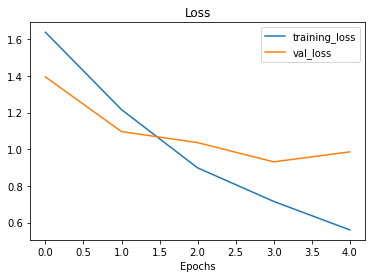

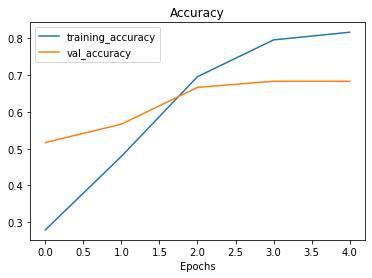

In [89]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)

In [90]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(6, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
8/8 [==============================] - 2s 62ms/step - loss: 1.5996 - accuracy: 0.3500 - val_loss: 1.2518 - val_accuracy: 0.5167
Epoch 2/5
8/8 [==============================] - 0s 38ms/step - loss: 1.0645 - accuracy: 0.6667 - val_loss: 0.9637 - val_accuracy: 0.6833
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.7234 - accuracy: 0.7708 - val_loss: 0.8296 - val_accuracy: 0.7667
Epoch 4/5
8/8 [==============================] - 0s 33ms/step - loss: 0.5875 - accuracy: 0.8167 - val_loss: 0.7764 - val_accuracy: 0.7000
Epoch 5/5
8/8 [==============================] - 0s 34ms/step - loss: 0.4778 - accuracy: 0.8292 - val_loss: 0.8521 - val_accuracy: 0.7000


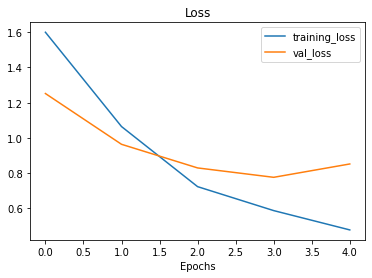

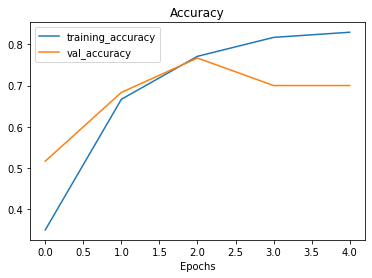

In [91]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

In [92]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)


train_data_augmented = train_datagen_augmented.flow(X_train, Y_train, batch_size=32, seed=42)

In [93]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
8/8 [==============================] - 4s 308ms/step - loss: 2.4828 - accuracy: 0.1875 - val_loss: 1.8180 - val_accuracy: 0.3000
Epoch 2/5
8/8 [==============================] - 3s 317ms/step - loss: 1.7015 - accuracy: 0.2750 - val_loss: 1.4192 - val_accuracy: 0.3833
Epoch 3/5
8/8 [==============================] - 3s 317ms/step - loss: 1.3805 - accuracy: 0.3958 - val_loss: 1.3543 - val_accuracy: 0.3833
Epoch 4/5
8/8 [==============================] - 2s 306ms/step - loss: 1.2445 - accuracy: 0.4792 - val_loss: 1.0782 - val_accuracy: 0.5667
Epoch 5/5
8/8 [==============================] - 3s 324ms/step - loss: 1.1120 - accuracy: 0.6042 - val_loss: 1.0133 - val_accuracy: 0.6667


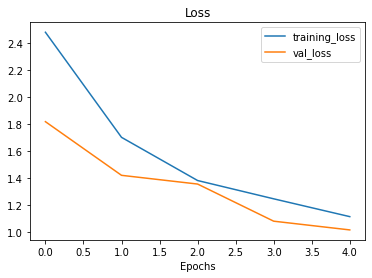

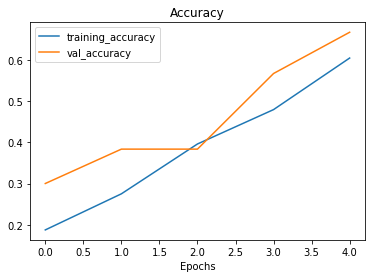

In [94]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

1/1 [==============================] - 0s 61ms/step


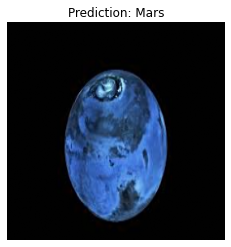

In [95]:
pred_and_plot(model_11, X_test/255., class_names)

### Binary Classification: Lambo or Rrari?!

In [96]:
parent_dir = '/content/drive/MyDrive/lambo_rrari/'

In [97]:
class_names = ['lambo', 'rrari']
(X, Y) = get_images_labels(parent_dir, class_names, resize=(224, 224))
# Y = tf.one_hot(Y, 6) # no need to one hot encode for binary

In [98]:
X_train, Y_train, X_test, Y_test = images_labels_split(X, Y, depth=2, split=.2)

In [99]:
X_train

array([[[[173, 184, 188],
         [178, 189, 193],
         [188, 199, 203],
         ...,
         [225, 227, 228],
         [213, 215, 215],
         [194, 196, 196]],

        [[175, 186, 190],
         [181, 192, 197],
         [191, 202, 206],
         ...,
         [226, 228, 229],
         [215, 217, 217],
         [194, 196, 196]],

        [[178, 189, 193],
         [186, 197, 200],
         [194, 205, 209],
         ...,
         [227, 229, 230],
         [216, 218, 218],
         [196, 198, 198]],

        ...,

        [[158, 153, 154],
         [154, 150, 150],
         [156, 154, 154],
         ...,
         [216, 218, 219],
         [214, 214, 214],
         [214, 214, 214]],

        [[147, 142, 144],
         [150, 146, 147],
         [154, 152, 152],
         ...,
         [214, 217, 217],
         [211, 211, 211],
         [211, 211, 211]],

        [[141, 136, 136],
         [147, 143, 144],
         [152, 150, 150],
         ...,
         [213, 215, 216],
        

In [100]:
Y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [101]:
len(Y_train)

160

In [102]:
X_test

array([[[[ 14,  37,  29],
         [ 22,  44,  36],
         [ 39,  59,  50],
         ...,
         [ 42,  64,  63],
         [ 40,  66,  67],
         [ 24,  48,  50]],

        [[ 31,  54,  46],
         [ 41,  63,  55],
         [ 52,  73,  64],
         ...,
         [ 60,  81,  82],
         [ 60,  86,  88],
         [ 44,  68,  70]],

        [[ 40,  62,  54],
         [ 54,  75,  67],
         [ 65,  86,  77],
         ...,
         [ 56,  78,  79],
         [ 62,  88,  90],
         [ 46,  69,  73]],

        ...,

        [[124, 125, 123],
         [167, 168, 166],
         [169, 170, 168],
         ...,
         [182, 183, 181],
         [178, 180, 177],
         [139, 140, 138]],

        [[116, 117, 115],
         [154, 155, 153],
         [154, 155, 153],
         ...,
         [167, 168, 166],
         [166, 167, 165],
         [129, 130, 128]],

        [[ 90,  91,  89],
         [121, 122, 121],
         [119, 121, 118],
         ...,
         [130, 131, 129],
        

In [103]:
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [104]:
len(Y_test)

40

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.)



In [106]:
train_data = datagen.flow(X_train, Y_train, batch_size=32, seed=42)

In [107]:
test_data = datagen.flow(X_test, Y_test, batch_size=32, seed=42)

In [108]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])


In [109]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [110]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
5/5 [==============================] - 2s 87ms/step - loss: 0.6889 - accuracy: 0.5375 - val_loss: 0.6861 - val_accuracy: 0.4500
Epoch 2/5
5/5 [==============================] - 0s 46ms/step - loss: 0.6692 - accuracy: 0.6125 - val_loss: 0.6656 - val_accuracy: 0.6750
Epoch 3/5
5/5 [==============================] - 0s 40ms/step - loss: 0.6576 - accuracy: 0.5625 - val_loss: 0.6589 - val_accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 0s 45ms/step - loss: 0.6129 - accuracy: 0.6812 - val_loss: 0.6526 - val_accuracy: 0.6500
Epoch 5/5
5/5 [==============================] - 0s 38ms/step - loss: 0.5930 - accuracy: 0.7437 - val_loss: 0.6299 - val_accuracy: 0.7000


Image shape: (224, 224, 3)


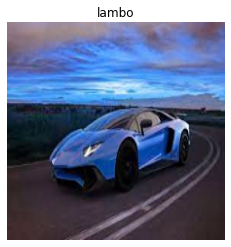

In [111]:
view_random_image(X, Y, class_names)

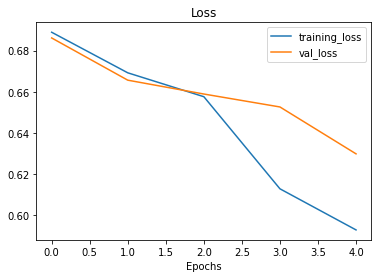

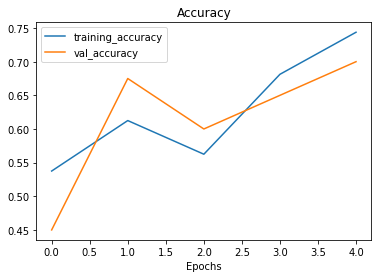

In [112]:
# Check out the loss curves of model_4
plot_loss_curves(history_5)

In [113]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis


In [114]:
train_data_augmented = train_datagen_augmented.flow(X_train, Y_train, batch_size=32, seed=42)

In [115]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
5/5 [==============================] - 3s 319ms/step - loss: 0.7310 - accuracy: 0.4500 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 2s 346ms/step - loss: 0.7063 - accuracy: 0.4375 - val_loss: 0.6906 - val_accuracy: 0.5250
Epoch 3/5
5/5 [==============================] - 2s 333ms/step - loss: 0.6887 - accuracy: 0.5312 - val_loss: 0.6798 - val_accuracy: 0.5250
Epoch 4/5
5/5 [==============================] - 2s 339ms/step - loss: 0.6834 - accuracy: 0.5813 - val_loss: 0.6771 - val_accuracy: 0.6500
Epoch 5/5
5/5 [==============================] - 2s 330ms/step - loss: 0.6848 - accuracy: 0.5375 - val_loss: 0.6739 - val_accuracy: 0.6000


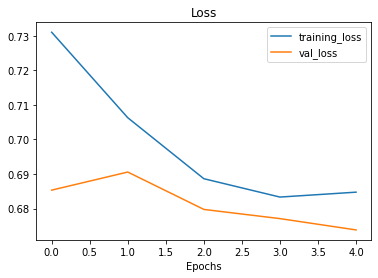

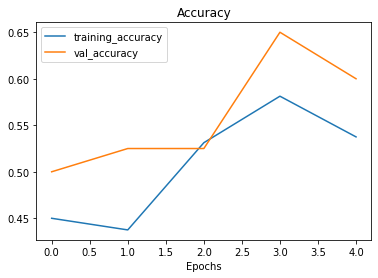

In [116]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

In [117]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow(X_train, Y_train, batch_size=32, seed=42, shuffle=True)

In [118]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
5/5 [==============================] - 3s 322ms/step - loss: 0.7159 - accuracy: 0.4938 - val_loss: 0.7114 - val_accuracy: 0.4500
Epoch 2/5
5/5 [==============================] - 2s 343ms/step - loss: 0.7135 - accuracy: 0.4563 - val_loss: 0.7060 - val_accuracy: 0.4250
Epoch 3/5
5/5 [==============================] - 2s 337ms/step - loss: 0.7229 - accuracy: 0.4750 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 4/5
5/5 [==============================] - 2s 337ms/step - loss: 0.6880 - accuracy: 0.5500 - val_loss: 0.7125 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 2s 333ms/step - loss: 0.6850 - accuracy: 0.5250 - val_loss: 0.6862 - val_accuracy: 0.5750


In [119]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(20, 7, activation='softplus', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(20, 7, activation='softplus'),
  MaxPool2D(),
  Conv2D(20, 7, activation='softplus'),
  Conv2D(20, 7, activation='softplus'),
  MaxPool2D(),  
  Conv2D(20, 7, activation='softplus'),
  Conv2D(20, 7, activation='softplus'),
  MaxPool2D(),
  Conv2D(100, 7, activation='softplus'),
  Conv2D(100, 7, activation='softplus'),
  MaxPool2D(),      
  Flatten(),
  Dense(1, activation='sigmoid')
])


from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, mode="max")
callbacks_list = [early_stop]


# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=50,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=callbacks_list
                        
                        )

Epoch 1/50
5/5 [==============================] - 5s 457ms/step - loss: 3.9530 - accuracy: 0.5375 - val_loss: 0.7226 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 2s 358ms/step - loss: 0.6982 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 2s 348ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 2s 345ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 2s 344ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 2s 342ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6: early stopping


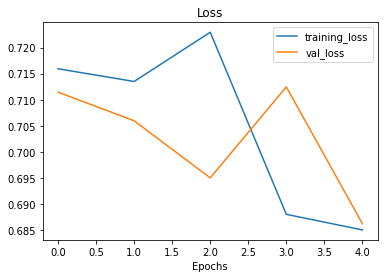

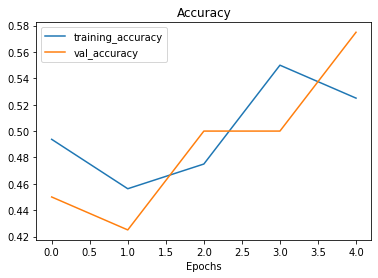

In [120]:
# Check out the TinyVGG model performance
plot_loss_curves(history_7)

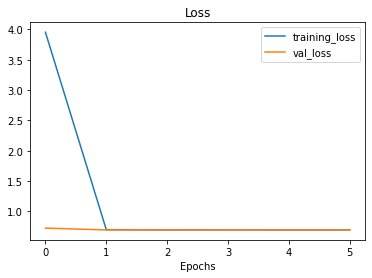

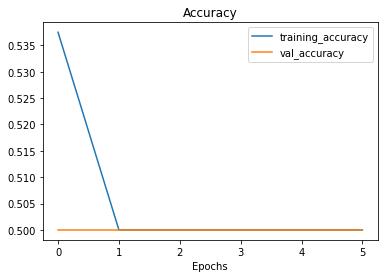

In [121]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

1/1 [==============================] - 0s 78ms/step


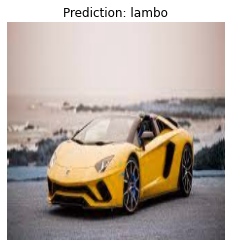

In [122]:
pred_and_plot(model_7, X_test, class_names)

1/1 [==============================] - 0s 110ms/step


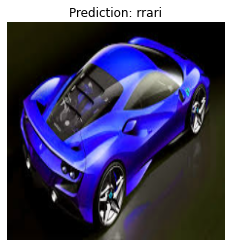

In [123]:
pred_and_plot(model_8, X_test, class_names)

In [124]:
# Are we using a GPU?
!nvidia-smi

Sun Mar 12 03:53:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    35W /  70W |  10553MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------